## Understanding all-cause mortality in the United States using Generalized Linear Models

This notebook uses generalized linear modeling (GLM) to understand
mortality in different demographic subgroups of the United States
population, and the way in which these mortality patterns vary over
time.  The data are from the U.S. Centers for Disease Control (CDC),
and cover 2007 to 2018.

See the `vital_stats_prep.py` script for more information about the
data, and to see the code used to assemble the data analyzed here.
You must run the `vital_stats_prep.py` script to create a data file
before running this script.

These are the Python modules that we will be using:

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

This is the path to the data file on your system.  You must change
this to point to the the pop_mort.csv data file on your system
('pop_mort.csv' is created by running the vital_stats_prep.py
script).

In [2]:
pa = "/nfs/kshedden/cdc_mortality/final/pop_mort.csv"
df = pd.read_csv(pa)

Below we can see what the data look like.

In [3]:
print(df.shape)
df.head()

(5184, 6)


,Year,Month,Sex,Deaths,Age_group,Population
0,2007,1,Female,1087,00_04,10029000
1,2007,1,Female,86,05_09,9693000
2,2007,1,Female,103,10_14,9970000
3,2007,1,Female,332,15_19,10423000
4,2007,1,Female,409,20_24,10123000


All of the GLM's we will be using here use the logarithm as their
link function.  Therefore we will use log-transformed population as
an offset, so that mortality is expressed relative to the population
size.

In [4]:
df.loc[:, "offset"] = np.log(df.Population)

A very important property that follows from using a model with the
log link function is that the regression effects are multiplicative.
In our setting, this means that the overall mortality is represented
as a product of terms attributable to specific risk factors.  For
example, suppose that a model tells us that men have 1.05 times
greater risk of dying than women.  This multiplicative factor
adjusts the base rate of death defined by the other variables.  So
if the death rate in January is 1.03 times greater than the death
rate in June, we can combine this with the multiplicative factor for
sex to obtain that the death rate for men in January is 1.05*1.03
times the death rate for women in June.

The above discussion applies to models with no interactions among
the risk factors.  If there are interactions, then the mortality for
men in January could be either greater than, or less than the
product of the main effect terms for men and for January, depending
on the sign and magnitude of the interaction term between sex and
month.  Below we will start by considering models having no
interactions, then we will consider models that have interactions.

## GLM and GEE estimation of models with no interactions

We begin by fitting an initial Poisson GLM treating all counts as
being independent.

In [5]:
fml = "Deaths ~ Age_group + Sex + C(Year) + C(Month)"
m1 = sm.GLM.from_formula(fml, family=sm.families.Poisson(), offset=df.offset, data=df)
r1 = m1.fit(scale="X2")

To see the parameter estimates, you can type `r1.summary()`.
However this model has quite a few parameters, so it is not easy to
understand the meaning of the model by studying the parameter
estimates.  Below we will demonstrate how to graph models like this
in order to better convey what they mean.

GLMs treat the observations (rows of data) as being independent.  It
is possible that circumstances such as weather and disease outbreaks
may introduce different forms of correlation into the mortality
counts.  We will not fully explore all the possibilities for
correlation structure here, but we will demonstrate the use of
generalized estimating equations (GEE) to fit a model in which
counts within the same year/month are dependent.

In a GEE, we specify a "group variable" such that observations in
the same group may be dependent (observations in different groups
must always be independent).  We also specify a "working correlation
structure" that defines how the observations within a group may be
statistically dependent.  This working correlation structure does
not need to be correct in order for the results to be meaningful.

Below we specify the group variable to be a single month of data
(which would consist of all mortality counts for females and males
of all different age groups within this month).  If a month has
unusual mortality, e.g. because it falls during an especially bad
flu season, then mortality for all age groups and both sexes may be
impacted.  We specify the working correlation structure to be
independent.  Due to the robustness properties of GEE discussed
above, we can obtain meaningful results from a working independence
model even though we suspect that the data are dependent.

In [6]:
df["yearmonth"] = 20*df.Year + df.Month
m2 = sm.GEE.from_formula(fml, family=sm.families.Poisson(), groups="yearmonth",
          offset=df.offset, cov_struct=sm.cov_struct.Independence(), data=df)
r2 = m2.fit(scale="X2")

The plot below shows how each parameter estimate compares when
estimated using GLM and when using GEE (Generalized Estimating
Equations).  As we can see, the parameter estimates are identical.
This always happens when using the independence working correlation
structure with GEE.

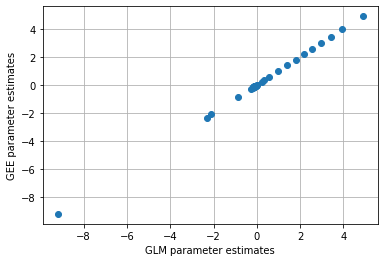

In [7]:
plt.grid(True)
plt.plot(r1.params, r2.params, 'o')
plt.xlabel("GLM parameter estimates")
_ = plt.ylabel("GEE parameter estimates")

The plot below shows the standard errors when using GLM and when
using GEE.  The relationship between standard errors in GLM and GEE
can be complex.  In this case, many of the standard errors are
larger for the GLM estimation compared to the GEE estimation.

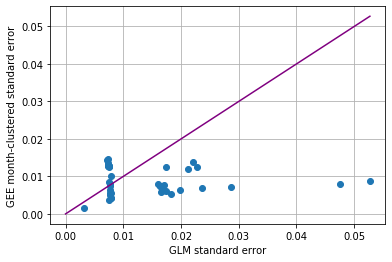

In [8]:
plt.grid(True)
plt.plot(r1.bse, r2.bse, 'o')
ma = max(r1.bse.max(), r2.bse.max())
plt.plot([0, ma], [0, ma], '-', color='purple')
plt.xlabel("GLM standard error")
_ = plt.ylabel("GEE month-clustered standard error")

As noted above, dependence structure in these data may take on
several forms.  One possibility, explored above, is that values
observed in the same calendar month are correlated.  Another
possibility is that there is temporal correlation within each age
band.  It is difficult to account for both possibilities at the same
time.  Below we use a stationary covariance model to capture serial
dependence of the mortality counts within each age band.

In [9]:
m3 = sm.GEE.from_formula(fml, family=sm.families.Poisson(), groups="Age_group",
          offset=df.offset, cov_struct=sm.cov_struct.Stationary(max_lag=3, grid=True),
          data=df)
r3 = m3.fit(maxiter=10, scale="X2")

print(m3.cov_struct.summary())

/nfs/kshedden/python3/lib/python3.7/site-packages/statsmodels/genmod/generalized_estimating_equations.py:1330: IterationLimitWarning: Iteration limit reached prior to convergence
  IterationLimitWarning)


   Lag       Cov
0    0  1.000000
1    1 -0.658383
2    2  0.960885
3    3 -0.685404


Below we show how the standard errors compare when using the
stationary GEE estimates compared to when using the independence
working correlation structure.

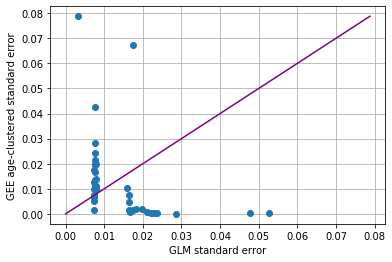

In [10]:
plt.grid(True)
plt.plot(r1.bse, r3.bse, 'o')
ma = max(r1.bse.max(), r3.bse.max())
plt.plot([0, ma], [0, ma], '-', color='purple')
plt.xlabel("GLM standard error")
_ = plt.ylabel("GEE age-clustered standard error")

A further complication is that the covariance structure depends on
the mean structure, and vice versa.  Here, we are comparing two
covariance structures (clustering by months, and clustering by age
bands) using a simple additive mean structure.  But below we will
find that the mean structure is likely not additive.  In a thorough
analysis, we would re-assess the covariance structure after making
further refinements to the mean structure.

## Models with interactions

Next we fit a series of models in which we consider pairwise
interactions between different types of variables.  As above, the
models have many parameters, so it is not very informative to view
the table of estimates.  Later we will use graphical methods to
better understand the meaning of these models.  In each case below,
we use a score test to assess the evidence that the moderating
relationship (i.e. the interaction) is real.  We begin by
considering whether age-specific mortality rates vary by sex.  The
score test results indicate that there is strong evidence for this.

In [11]:
fml4 = "Deaths ~ Age_group * Sex + C(Year) + C(Month)"
m4 = sm.GEE.from_formula(fml4, family=sm.families.Poisson(), groups="yearmonth",
          offset=df.offset, cov_struct=sm.cov_struct.Independence(), data=df)
r4 = m4.fit(scale="X2")

print(m4.compare_score_test(r2))

{'statistic': 143.35091187649064, 'df': 17, 'p-value': 0.0}


Next we assess whether the seasonality patterns vary by sex.  There
is strong evidence for this moderation as well.

In [12]:
fml5 = "Deaths ~ (Age_group + C(Month)) * Sex + C(Year)"
m5 = sm.GEE.from_formula(fml5, family=sm.families.Poisson(), groups="yearmonth",
          offset=df.offset, cov_struct=sm.cov_struct.Independence(), data=df)
r5 = m5.fit(scale="X2")

print(m5.compare_score_test(r4))

{'statistic': 56.97281165814389, 'df': 11, 'p-value': 3.3659033782384995e-08}


There is also strong evidence that the long term trend varies by
sex.

In [13]:
fml6 = "Deaths ~ (Age_group + C(Year) + C(Month)) * Sex"
m6 = sm.GEE.from_formula(fml6, family=sm.families.Poisson(), groups="yearmonth",
          offset=df.offset, cov_struct=sm.cov_struct.Independence(), data=df)
r6 = m6.fit(scale="X2")

print(m6.compare_score_test(r5))

{'statistic': 72.83475421673059, 'df': 11, 'p-value': 3.5209168913752364e-11}


Below we check whether the sex-specific seasonality patterns vary by
year.  There isn't much evidence for this form of moderation.

In [14]:
fml7 = "Deaths ~ (Age_group + C(Year) * C(Month)) * Sex"
m7 = sm.GEE.from_formula(fml7, family=sm.families.Poisson(), groups="yearmonth",
          offset=df.offset, cov_struct=sm.cov_struct.Independence(), data=df)
r7 = m7.fit()

print(m7.compare_score_test(r6))

{'statistic': 144.00000000011164, 'df': 242, 'p-value': 0.9999999128073274}


## Visualization of model structures

Now that we have used hypothesis testing to assess which moderating
effects might be real, we can look at the effect sizes to understand
the patterns of moderation in more detail.  First, we plot the age
group effects by sex.  The values plotted on the vertical axis can
be differenced to obtain log risk ratios.  These results hold for
all months and all years.

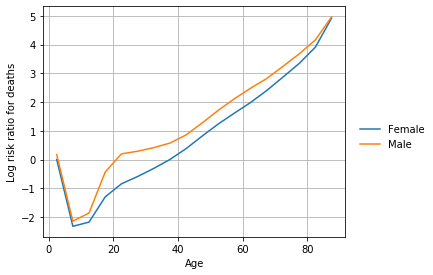

In [15]:
# These are the ages that are plotted along the horizontal axis
ages = ["%02d_%02d" % (a, a+4) for a in range(5, 90, 5)]
an = [a+2.5 for a in range(0, 90, 5)]
ages[-1] = "85_99"

# These are the parameters that we will use to obtain log risk ratios.
pa = r6.params.to_dict()

# These are the contributions of age and sex to the model.
xf = [0] + [pa['Age_group[T.%s]' % a] for a in ages]
xm = [0] + [pa['Age_group[T.%s]:Sex[T.Male]' % a] for a in ages]
xf = np.asarray(xf)
xm = np.asarray(xm)
xm += pa['Sex[T.Male]']

# Plot the age and sex effects
plt.clf()
plt.axes([0.1, 0.1, 0.7, 0.8])
plt.grid(True)
plt.plot(an, xf, label="Female")
plt.plot(an, xf + xm, label="Male")
plt.xlabel("Age")
plt.ylabel("Log risk ratio for deaths")
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, "center right")
leg.draw_frame(False)

Next we plot the male/female log risk ratio by age group.  This
shows how much more likely a male is to die than a female in each
month.  This effect holds for all age groups in all years.

Text(0, 0.5, 'Male/female log risk ratio')

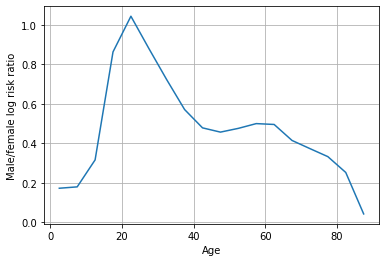

In [16]:
plt.grid(True)
plt.plot(an, xm, label="Male")
plt.xlabel("Age")
plt.ylabel("Male/female log risk ratio")

Next we consider the mortality risk by month for females and males.
This reflects a seasonal pattern of mortality in which mortality is
lowest in the summer and highest in the winter.  To obtain a risk
ratio between any two groups, subtract the log risk values in the
plot below and exponentiate this difference.

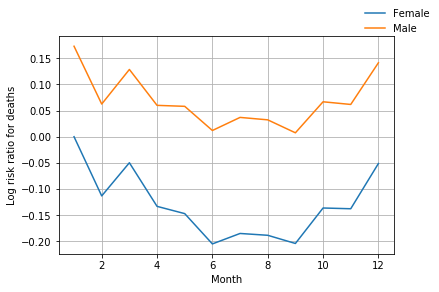

In [17]:
months = range(1, 13)
xf = [0] + [pa['C(Month)[T.%d]' % m] for m in range(2, 13)]
xm = [0] + [pa['C(Month)[T.%d]:Sex[T.Male]' % m] for m in range(2, 13)]
xf = np.asarray(xf)
xm = np.asarray(xm)
xm += pa['Sex[T.Male]']

plt.grid(True)
plt.plot(months, xf, label="Female")
plt.plot(months, xf + xm, label="Male")
plt.xlabel("Month")
plt.ylabel("Log risk ratio for deaths")
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb)
leg.draw_frame(False)

The score test conducted above indicates that the seasonal pattern
of mortality differs between women and men.  From the plot above,
the detailed pattern of this difference is not very clear.  We can
get more insight into this by plotting the male/female log risk
ratio by month.  This plot makes it more clear that mortality for
men is flatter through the year, while mortality for women has a
more pronounced drop during the summer.

Text(0, 0.5, 'Male/female log risk ratio')

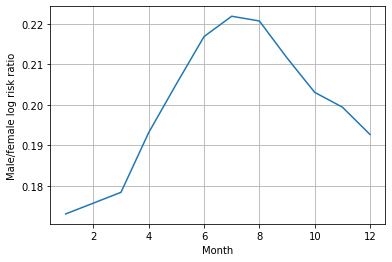

In [18]:
plt.grid(True)
plt.plot(months, xm, label="Male")
plt.xlabel("Month")
plt.ylabel("Male/female log risk ratio")

Next we consider any "long term trend" in the data, that is,
patterns of mortality variation that evolve continuously over
multiple years.  To assess this, we first plot the female and male
log risk ratio for death by year.  To obtain a risk ratio, take the
difference between any two points on these curves and exponentiate
it.  We see that mortality has generally declined for both sexes
during the duration covered by the data.  Mortality for males
increased slightly in 2014 and 2015, perhaps due to the opioid
epidemic.

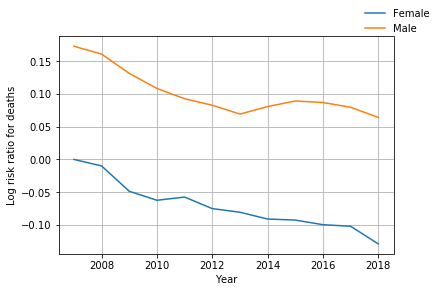

In [19]:
# These are the contributions of age and sex to the model.
years = range(2008, 2019)
xf = [0] + [pa['C(Year)[T.%4d]' % y] for y in years]
xm = [0] + [pa['C(Year)[T.%4d]:Sex[T.Male]' % y] for y in years]
xf = np.asarray(xf)
xm = np.asarray(xm)
xm += pa['Sex[T.Male]']

plt.grid(True)
years = [2007] + list(years)
plt.plot(years, xf, label="Female")
plt.plot(years, xf + xm, label="Male")
plt.xlabel("Year")
plt.ylabel("Log risk ratio for deaths")
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb)
leg.draw_frame(False)

Below we plot the male/female log risk ratio by year Between 2011
and 2013, male mortality dropped faster than female mortality, so
the gap between female and mortality was smallest during that
period.  Since 2013, the gap has grown again.

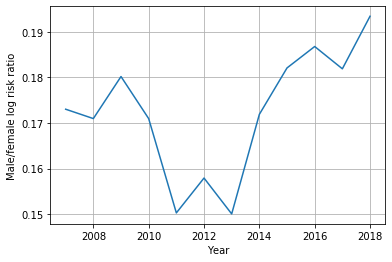

In [20]:
plt.grid(True)
plt.plot(years, xm, label="Male")
plt.xlabel("Year")
_ = plt.ylabel("Male/female log risk ratio")

## Residual analysis

The analysis above is based on a Poisson quasi-likelihood approach.
This is a regression framework in which the conditional mean and the
covariates are related through the log link function, and the
conditional variance is required to be a constant multiple of the
conditional mean.  This constant multiple is given by the scale
parameter as shown below

In [21]:
r6.scale

16.707568436073487

To assess whether the variance of the data is compatible with the
quasi-Poisson variance structure, we can take a look at the
residuals.  We bin the residuals according to the value of the
estimated conditional mean, then calculate the mean and variance
within each bin.  We then plot the log conditional variance against
the log conditional mean (we use the log to make the pattern easier
to see).  As long as this log/log plot has a slope close to 1, the
conditional variance and conditional mean are approximately
proportional.

Text(0, 0.5, 'Log conditional variance')

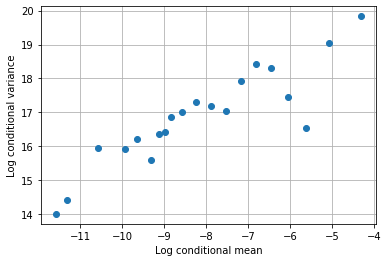

In [22]:
qt = pd.qcut(r6.fittedvalues, 20)
qt.name = "group"
qt = pd.DataFrame(qt)
qt["resid"] = r6.resid_pearson / np.sqrt(r6.scale)
qt["fittedvalues"] = r6.fittedvalues
qa = qt.groupby("group").agg({"fittedvalues": np.mean, "resid": np.var})

plt.grid(True)
plt.plot(np.log(qa.fittedvalues), np.log(qa.resid), 'o')
plt.xlabel("Log conditional mean")
plt.ylabel("Log conditional variance")